# How much decimation is too much? A varifold perspective

Before, we asked the question [How much decimation is too much?](./decimation_charlen.ipynb).

Here, we provide a different perspective using a varifold distance.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import polpo.preprocessing.dict as ppdict
from polpo.mesh.surface import PvSurface
from polpo.mesh.varifold.tuning import SigmaFromLengths
from polpo.preprocessing import BranchingPipeline, IdentityStep
from polpo.preprocessing.load.pregnancy.jacobs import MeshLoader
from polpo.preprocessing.mesh.decimation import PvDecimate

[KeOps] Warning : CUDA was detected, but driver API could not be initialized. Switching to CPU only.


In [2]:
session_subset = np.random.choice(np.arange(1, 27))

mesh_loader = (
    MeshLoader(
        subject_subset=["01"],
        struct_subset=["L_Hipp"],
        session_subset=[session_subset],
        derivative="enigma",
        as_mesh=True,
    )
    + ppdict.ExtractUniqueKey(nested=True)
    + PvSurface
)

raw_mesh = mesh_loader()

session_subset

np.int64(6)

In [3]:
decimation_targets = [0.99, 0.95, 0.9, 0.8, 0.6, 0.5, 0.2, 0]


multi_decimation_pipe = BranchingPipeline(
    [
        (
            PvDecimate(target_reduction=target_reduction, volume_preservation=True)
            + PvSurface
            if target_reduction
            else IdentityStep()
        )
        for target_reduction in decimation_targets
    ],
    merger=lambda data: dict(zip(decimation_targets, data)),
)

meshes = multi_decimation_pipe(raw_mesh)


[mesh.n_points for mesh in meshes.values()]

[27, 127, 252, 502, 1002, 1252, 2002, 2502]

We select the varifold kernel [using characteristic lengths](../how_to/varifold_kernel_charlen.ipynb).

In [4]:
sigma_search = SigmaFromLengths(
    ratio_charlen_mesh=2.0,
    ratio_charlen=0.25,
)

sigma_search.fit([raw_mesh])

metric = sigma_search.optimal_metric_

In [5]:
dists = [metric.squared_dist(raw_mesh, mesh) for mesh in meshes.values()]

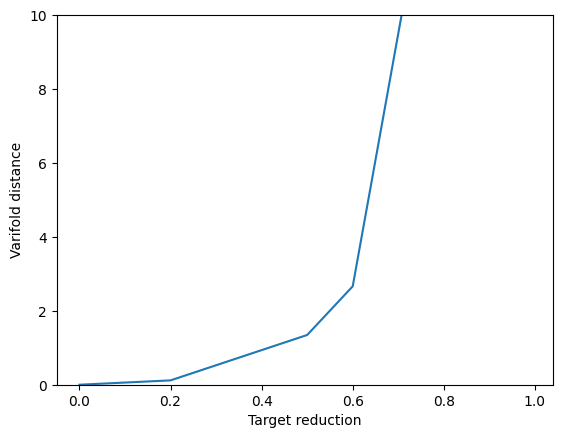

In [6]:
_, ax = plt.subplots()


ax.plot(decimation_targets, dists)
ax.set_ylim(0, 10)

ax.set_xlabel("Target reduction")
ax.set_ylabel("Varifold distance");

These values become particularly relevant when we start looking at [datasets](./varifold_distance_dataset.ipynb).

## Further reading

* [How much decimation is too much?](./decimation_charlen.ipynb)

* [Pairwise distances between different parametrizations of the same shape](./varifold_decimation_charlen.ipynb)

* [Within dataset varifold distances](./varifold_distance_dataset.ipynb)

